<a href="https://colab.research.google.com/github/google/jax-md/blob/master/notebooks/minimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Imports & Utils

!pip install jax-md

import numpy as onp

import jax.numpy as np
from jax.config import config
config.update('jax_enable_x64', True)

from jax import random
from jax import jit

from jax_md import space, smap, energy, minimize, quantity, simulate
from jax_md.colab_tools import renderer

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
  
sns.set_style(style='white')

def format_plot(x, y):  
  plt.grid(True)
  plt.xlabel(x, fontsize=20)
  plt.ylabel(y, fontsize=20)
  
def finalize_plot(shape=(1, 1)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1], 
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

# Harmonic Minimization

Here we demonstrate some simple example code showing how we might find the inherent structure for some initially random configuration of particles. Note that this code will work on CPU, GPU, or TPU out of the box.

First thing we need to do is set some parameters that define our simulation, including what kind of box we're using (specified using a metric function and a wrapping function).

In [39]:
N = 5000
dimension = 2
box_size = quantity.box_size_at_number_density(N, 0.8, 2)
displacement, shift = space.periodic(box_size) 

Next we need to generate some random positions as well as particle sizes.

In [40]:
key = random.PRNGKey(0)

In [41]:
R = box_size * random.uniform(key, (N, dimension), dtype=np.float32)

# The system ought to be a 50:50 mixture of two types of particles, one
# large and one small.
sigma = np.array([[1.0, 1.2], [1.2, 1.4]])
N_2 = int(N / 2)
species = np.where(np.arange(N) < N_2, 0, 1)

Then we need to construct our FIRE minimization function. Like all simulations in JAX MD, the FIRE optimizer is two functions: an `init_fn` that creates the state of the optimizer and an `apply_fn` that updates the state to a new state.

In [42]:
energy_fn = energy.soft_sphere_pair(displacement, species=species, sigma=sigma)
fire_init, fire_apply = minimize.fire_descent(energy_fn, shift)
fire_apply = jit(fire_apply)
fire_state = fire_init(R)

Now let's actually do minimization, keepting track of the energy and particle positions as we go.

In [43]:
E = []
trajectory = []

for i in range(200):
  fire_state = fire_apply(fire_state)
  
  E += [energy_fn(fire_state.position)]
  trajectory += [fire_state.position]
  
R = fire_state.position
trajectory = np.stack(trajectory)

Let's plot the nearest distance for different species pairs. We see that particles on average have neighbors that are the right distance apart.

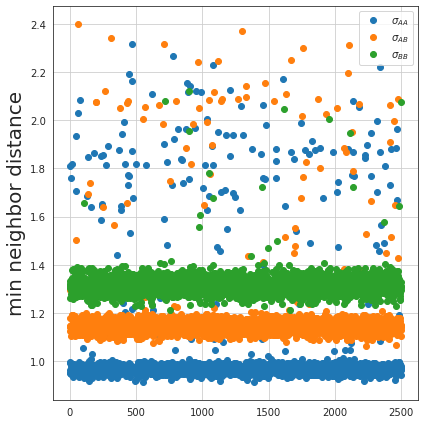

In [44]:
metric = lambda R: space.distance(space.map_product(displacement)(R, R))
dr = metric(R)
plt.plot(np.min(dr[:N_2, :N_2] + 5 * np.eye(N_2, N_2), axis=0), 'o', 
         label='$\\sigma_{AA}$')
plt.plot(np.min(dr[:N_2, N_2:] + 5 * np.eye(N_2, N_2), axis=0), 'o',
         label='$\\sigma_{AB}$')
plt.plot(np.min(dr[N_2:, N_2:] + 5 * np.eye(N_2, N_2), axis=0), 'o',
         label='$\\sigma_{BB}$')

plt.legend()
format_plot('', 'min neighbor distance')
finalize_plot()

Now let's plot the system. It's nice and minimized!

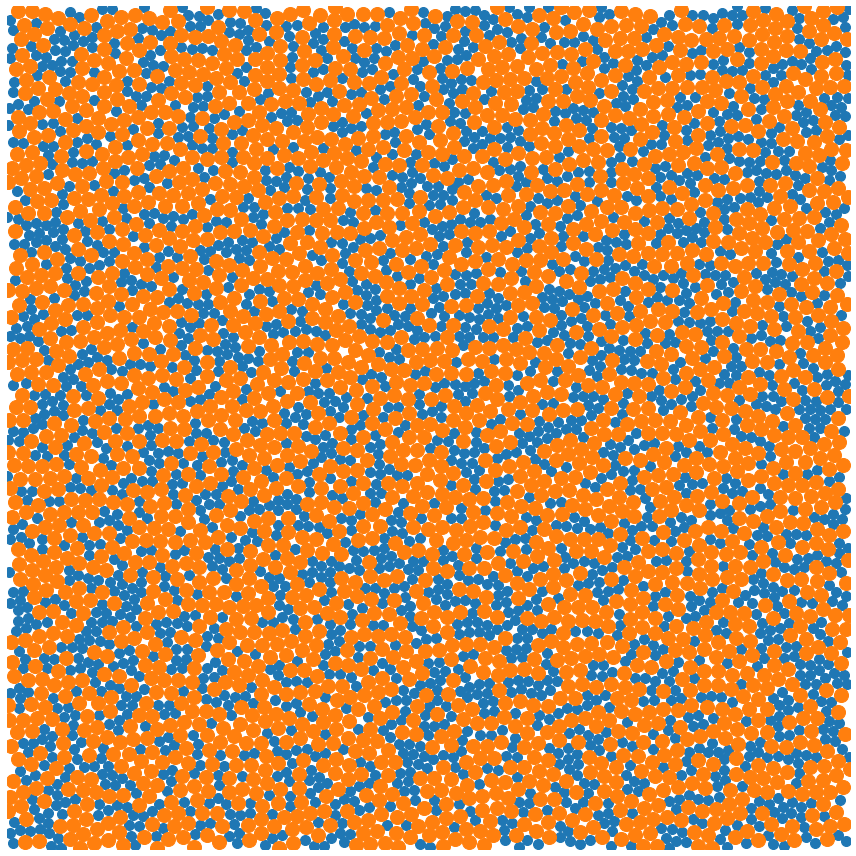

In [45]:
ms = 20
R_plt = onp.array(fire_state.position)

plt.plot(R_plt[:N_2, 0], R_plt[:N_2, 1], 'o', markersize=ms * 0.5)
plt.plot(R_plt[N_2:, 0], R_plt[N_2:, 1], 'o', markersize=ms * 0.7)

plt.xlim([0, np.max(R[:, 0])])
plt.ylim([0, np.max(R[:, 1])])

plt.axis('off')

finalize_plot((2, 2))

If we want, we can visualize the entire minimization.

In [49]:
diameter = np.where(species, 1.4, 1.0)
color = np.where(species[:, None], 
                 np.array([[1.0, 0.5, 0.05]]), 
                 np.array([[0.15, 0.45, 0.8]]))
renderer.render(box_size, 
                { 'particles': renderer.Disk(trajectory, diameter, color)},
                buffer_size=50)

Finally, let's plot the energy trajectory that we observer during FIRE minimization.

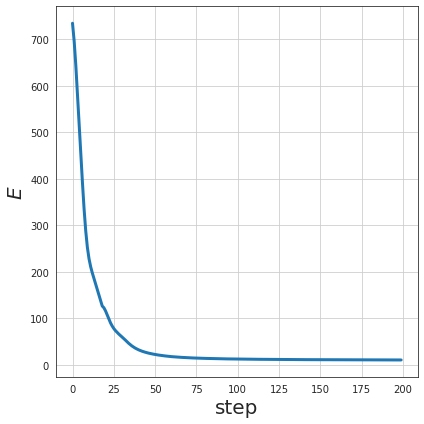

In [48]:
plt.plot(E, linewidth=3)

format_plot('step', '$E$')
finalize_plot()